In [10]:
from joblib import load
from tqdm import tqdm
import json

true_prob = []
sample_to_read = []
i = 0
files = []
template = {}
# read json file
with open("../../dataset/adv_rob/advglue++/data/alpaca.json", "r") as f:
    data = json.load(f)
for key in data.keys():
    files.append(key)
    temp = {}
    for sample in data[key]:
        for k in sample.keys():
            if k not in temp.keys():
                temp[k] = 1
            else:
                temp[k] += 1
    template[key] = temp

print(files)
for i in files:
    print(i, template[i])
    print("=====================================")




['sst2', 'mnli', 'mnli-mm', 'qqp', 'qnli', 'rte']
sst2 {'idx': 2125, 'sentence': 2125, 'original_sentence': 2125, 'label': 2125, 'method': 2125, 'data_construction': 2125}
mnli {'idx': 1696, 'sentence': 1193, 'original_sentence': 1193, 'label': 1696, 'method': 1696, 'data_construction': 1696, 'premise': 503, 'hypothesis': 503, 'original_hypothesis': 214, 'original_premise': 289}
mnli-mm {'idx': 1609, 'sentence': 1122, 'original_sentence': 1122, 'label': 1609, 'method': 1609, 'data_construction': 1609, 'premise': 487, 'hypothesis': 487, 'original_hypothesis': 209, 'original_premise': 278}
qqp {'idx': 1080, 'sentence': 389, 'original_sentence': 389, 'label': 1080, 'method': 1080, 'data_construction': 1080, 'question1': 691, 'question2': 691, 'original_question2': 543, 'original_question1': 148}
qnli {'idx': 4550, 'sentence': 4550, 'original_sentence': 3829, 'label': 4550, 'method': 4550, 'data_construction': 4550, 'question': 1958, 'original_question': 721}
rte {'idx': 424, 'sentence': 6

In [2]:
import pickle
from sklearn.model_selection import train_test_split

def load_lists(filename):
    with open(filename, 'rb') as f:
        list1, list2, list3 = pickle.load(f)
    return list1, list2, list3

train_instance_2, val_instance_2, test_instance_2 = load_lists('31/hidden_states_GMM_200_1024_0.2_1.pkl')

train_ground_truth_2 = [i["binary_label"] for i in train_instance_2]
test_ground_truth_2 = [i["binary_label"] for i in test_instance_2]
train_traces = [i["state_trace"] for i in train_instance_2]
test_traces = [i["state_trace"] for i in test_instance_2]

print(len(train_instance_2))
print(len(test_instance_2))
print(train_instance_2)


train_set_train_traces, test_set_train_traces = train_test_split(train_traces, test_size=0.2, random_state=42)





9187
6791
[{'is_attack_success': 1, 'hidden_states': None, 'binary_label': 0, 'output': '0.9', 'is_adversarial': 0, 'hidden_states_block_id': [31], 'adv_dataset': 'qnli', 'adv_method': 'original', 'data_construction': 'word', 'state_trace': [71, 15, 104, 65, 1], 'step_by_step_attention_heads': None, 'step_by_step_attention_blocks': None}, {'is_attack_success': 1, 'hidden_states': None, 'binary_label': 0, 'output': 'Answer: Yes\nConfidence Score: 1', 'is_adversarial': 0, 'hidden_states_block_id': [31], 'adv_dataset': 'qnli', 'adv_method': 'original', 'data_construction': 'word', 'state_trace': [4, 14, 12, 11, 19, 37, 49, 13, 179, 188, 136, 5, 1], 'step_by_step_attention_heads': None, 'step_by_step_attention_blocks': None}, {'is_attack_success': 0, 'hidden_states': None, 'binary_label': 1, 'output': '0', 'is_adversarial': 0, 'hidden_states_block_id': [31], 'adv_dataset': 'mnli', 'adv_method': 'original', 'data_construction': 'word', 'state_trace': [55, 112, 1], 'step_by_step_attention_he

In [16]:
from collections import Counter


def sliding_window(sequence, window_size):
    """Generate sub-sequences of window_size from sequence."""
    return [sequence[i : i + window_size] for i in range(len(sequence) - window_size + 1)]

def count_subsequences(traces, window_size):
    """Count the occurrence of each sub-sequence of window_size in traces."""
    counter = Counter()
    for trace in traces:
        for subsequence in sliding_window(trace, window_size):
            # Convert list of integers to a hashable type to count them
            subsequence_tuple = tuple(subsequence)
            counter[subsequence_tuple] += 1
    return counter

in_distribution_traces = train_traces
ood_distribution_traces = test_traces
in_distribution_traces_test = test_set_train_traces

# Choose a window size
window_size = 2

# Count sub-sequence occurrences
in_distribution_counts = count_subsequences(train_set_train_traces, window_size)
ood_counts = count_subsequences(ood_distribution_traces, window_size)
in_distribution_counts_test = count_subsequences(in_distribution_traces_test, window_size)

high_freq_pairs_ood = [(subseq, count) for subseq, count in in_distribution_counts.items() if count > 1 and ood_counts[subseq] == 0]
high_freq_pairs_id_test = [(subseq, count) for subseq, count in in_distribution_counts_test.items() if count > 1 and in_distribution_counts[subseq] == 0]

# Sort the pairs by frequency in descending order
high_freq_pairs_ood.sort(key=lambda x: x[1], reverse=True)
high_freq_pairs_id_test.sort(key=lambda x: x[1], reverse=True)

# Print the result
print("=====================================")
print("top 10 of original", in_distribution_counts.most_common(10))
print("top 10 of advsarial", ood_counts.most_common(10))

print("length of id training set", len(train_set_train_traces))
print("length of ood set", len(ood_distribution_traces))
print("length of id test set", len(in_distribution_traces_test))
print("Pairs on ID training set that are not in OOD set:")
for subseq, count in high_freq_pairs_ood[:10]:
    print(f"Sub-sequence: {subseq}, Frequency in ID: {count}")

print("=====================================")

print("Pairs on ID training set that are not in ID test set:")
for subseq, count in high_freq_pairs_id_test[:10]:
    print(f"Sub-sequence: {subseq}, Frequency in ID: {count}")



316 79 249
original_counts Counter({(26, 115, 1): 45, (33, 37, 1): 45, (47, 21, 1): 32, (100, 176, 1): 25, (47, 76, 1): 22, (33, 176, 1): 19, (2, 21, 1): 18, (100, 7, 1): 15, (100, 115, 1): 12, (33, 21, 1): 11, (26, 37, 1): 8, (26, 176, 1): 7, (100, 37, 1): 7, (119, 21, 1): 6, (119, 176, 1): 5, (2, 30, 1): 5, (33, 7, 1): 4, (119, 7, 1): 4, (119, 115, 1): 3, (33, 115, 1): 3, (33, 30, 1): 3, (119, 30, 1): 3, (26, 7, 1): 2, (47, 30, 1): 2, (47, 36, 1): 2, (2, 37, 1): 2, (119, 76, 1): 1, (33, 7, 188): 1, (7, 188, 159): 1, (188, 159, 136): 1, (159, 136, 136): 1, (136, 136, 159): 1, (136, 159, 159): 1, (159, 159, 136): 1, (159, 136, 151): 1, (136, 151, 1): 1, (26, 30, 1): 1, (26, 21, 1): 1, (2, 7, 1): 1})
adv_counts Counter({(136, 136, 136): 88, (30, 30, 1): 48, (30, 30, 30): 35, (186, 30, 1): 13, (57, 30, 30): 10, (57, 186, 51): 8, (186, 51, 1): 8, (57, 186, 30): 8, (30, 186, 30): 5, (30, 136, 136): 3, (30, 30, 7): 2, (30, 7, 1): 2, (136, 136, 7): 2, (7, 30, 30): 2, (136, 136, 1): 1, (57, 3

In [33]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc

def get_roc_auc(fake_probs, test_trace, test_ground_truth):
    percentage_result = []
    for sentence in test_trace:
        # Map the sentence tokens to their fake probabilities
        sentence_probs = [fake_probs[token] for token in sentence]

        # Calculate the mean fake probability for the sentence
        mean_prob = sum(sentence_probs) / len(sentence_probs)

        # Classify the sentence as fake if mean_prob > 0.5, true otherwise
        percentage_result.append(mean_prob * (-1))

    # ROC AUC Score

    fpr, tpr, thresholds = roc_curve(test_ground_truth, percentage_result)
    roc_auc = auc(fpr, tpr)
    print(f'ROC AUC Score: {roc_auc}')
    return fpr, tpr, roc_auc

fpr_1, tpr_1, roc_auc_1 = get_roc_auc(fake_probs_1, test_trace_1, test_ground_truth_1)
fpr_2, tpr_2, roc_auc_2 = get_roc_auc(fake_probs_2, test_trace_2, test_ground_truth_2)
fpr_3, tpr_3, roc_auc_3 = get_roc_auc(fake_probs_3, test_trace_3, test_ground_truth_3)
fpr_4, tpr_4, roc_auc_4 = get_roc_auc(fake_probs_4, test_trace_4, test_ground_truth_4)

fpr_1_train, tpr_1_train, roc_auc_1_train = get_roc_auc(fake_probs_1_train, train_trace_1, train_ground_truth_1)
fpr_2_train, tpr_2_train, roc_auc_2_train = get_roc_auc(fake_probs_2_train, train_trace_2, train_ground_truth_2)
fpr_3_train, tpr_3_train, roc_auc_3_train = get_roc_auc(fake_probs_3_train, train_trace_3, train_ground_truth_3)
fpr_4_train, tpr_4_train, roc_auc_4_train = get_roc_auc(fake_probs_4_train, train_trace_4, train_ground_truth_4)


# Plot ROC curve
# plt.figure()
# lw = 2
# plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic example')
# plt.legend(loc="lower right")
# plt.show()

ROC AUC Score: 0.9103277674706246
ROC AUC Score: 0.842542270531401
ROC AUC Score: 0.7981591285162714
ROC AUC Score: 0.8139525753768845
ROC AUC Score: 0.7567342157121355
ROC AUC Score: 0.7799801488833746
ROC AUC Score: 0.8039445244956773
ROC AUC Score: 0.8129266508776818


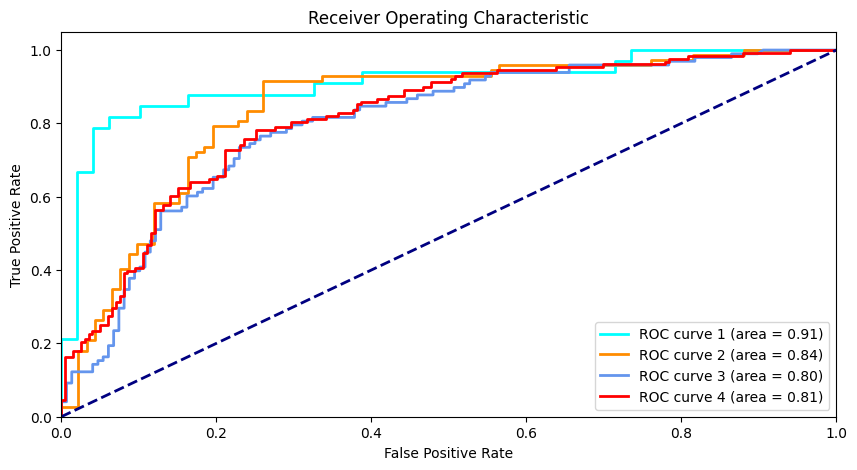

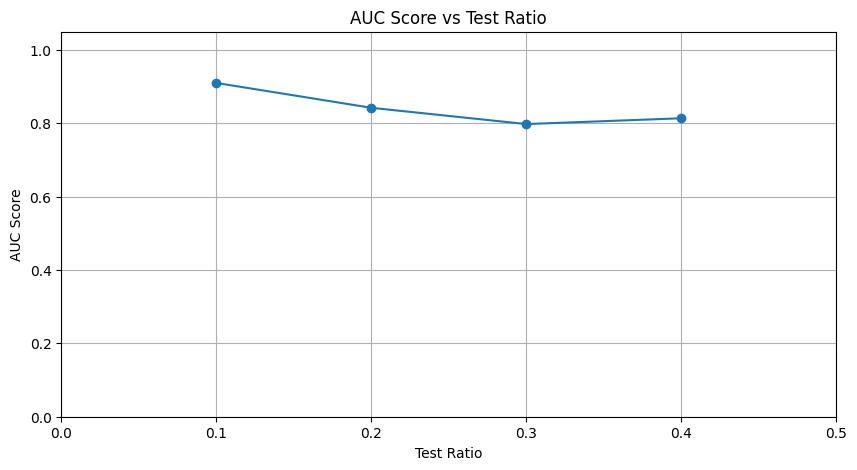

In [34]:
import matplotlib.pyplot as plt
# Create a list of test ratios
test_ratios = [0.1, 0.2, 0.3, 0.4]

# Create a list of your roc_auc scores
roc_aucs = [roc_auc_1, roc_auc_2, roc_auc_3, roc_auc_4]

# Create a list of colors for your ROC curves
colors = ['aqua', 'darkorange', 'cornflowerblue', 'red']

# Create a list of your fpr and tpr values
fpr_values = [fpr_1, fpr_2, fpr_3, fpr_4]
tpr_values = [tpr_1, tpr_2, tpr_3, tpr_4]

plt.figure(figsize=(10,5))

# Plot each ROC curve
for i, color in zip(range(4), colors):
    plt.plot(fpr_values[i], tpr_values[i], color=color, lw=2, label=f'ROC curve {i+1} (area = %0.2f)' % roc_aucs[i])
    
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot the AUC scores
plt.figure(figsize=(10,5))
plt.plot(test_ratios, roc_aucs, marker='o')
plt.xlim([0.0, 0.5])
plt.ylim([0.0, 1.05])
plt.xlabel('Test Ratio')
plt.ylabel('AUC Score')
plt.title('AUC Score vs Test Ratio')
plt.grid(True)
plt.show()

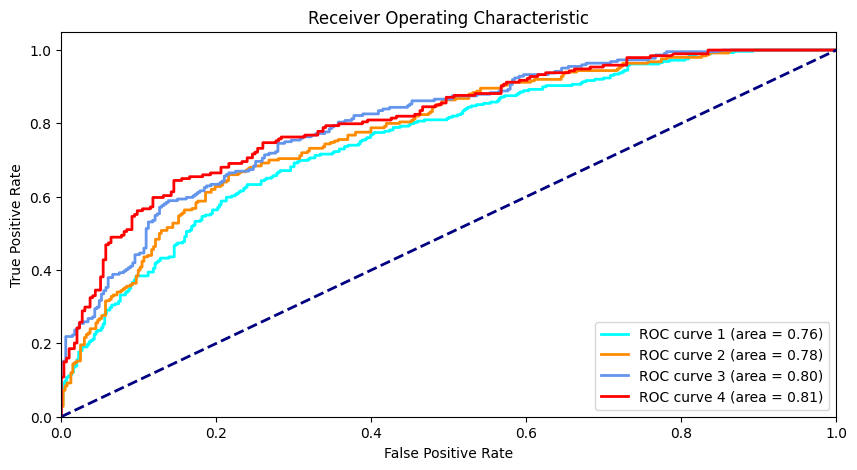

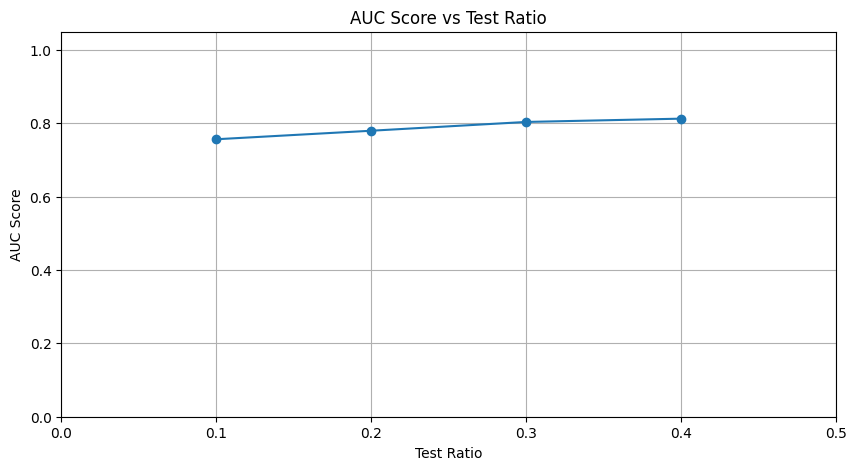

In [35]:
import matplotlib.pyplot as plt
# Create a list of test ratios
test_ratios = [0.1, 0.2, 0.3, 0.4]

# Create a list of your roc_auc scores
roc_aucs = [roc_auc_1_train, roc_auc_2_train, roc_auc_3_train, roc_auc_4_train]

# Create a list of colors for your ROC curves
colors = ['aqua', 'darkorange', 'cornflowerblue', 'red']

# Create a list of your fpr and tpr values
fpr_values = [fpr_1_train, fpr_2_train, fpr_3_train, fpr_4_train]
tpr_values = [tpr_1_train, tpr_2_train, tpr_3_train, tpr_4_train]

plt.figure(figsize=(10,5))

# Plot each ROC curve
for i, color in zip(range(4), colors):
    plt.plot(fpr_values[i], tpr_values[i], color=color, lw=2, label=f'ROC curve {i+1} (area = %0.2f)' % roc_aucs[i])
    
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot the AUC scores
plt.figure(figsize=(10,5))
plt.plot(test_ratios, roc_aucs, marker='o')
plt.xlim([0.0, 0.5])
plt.ylim([0.0, 1.05])
plt.xlabel('Test Ratio')
plt.ylabel('AUC Score')
plt.title('AUC Score vs Test Ratio')
plt.grid(True)
plt.show()

In [36]:
# import pandas as pd
# import numpy as np

# def extract_features(arr):
#     # Feature extraction for each array
#     mean = np.mean(arr)
#     std = np.std(arr)
#     max_value = np.max(arr)
#     min_value = np.min(arr)
#     # ... add any other features you find useful

#     return [mean, std, max_value, min_value]

# # Extract features from each array and convert to pandas DataFrame
# features = np.array([extract_features(arr) for arr in loaded_list1])
# df = pd.DataFrame(features, columns=['mean', 'std', 'max', 'min'])
# df['label'] = loaded_list2

In [37]:
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc

# # Split into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(df.drop('label', axis=1), df['label'], test_size=0.2, random_state=42)

# # Initialize and train classifier
# classifier = LogisticRegression()
# classifier.fit(X_train, y_train)

# # Evaluate classifier
# score = classifier.score(X_test, y_test)
# print(f"Test accuracy: {score * 100}%")


In [38]:
# # Creating and training a Random Forest Classifier
# classifier = RandomForestClassifier(n_estimators=100, random_state=42)
# classifier.fit(X_train, y_train)

# # Predicting on the testing set
# y_pred = classifier.predict(X_test)
# print(y_pred)
# print("Accuracy: ", accuracy_score(y_test, y_pred))

# # Confusion Matrix
# conf_matrix = confusion_matrix(y_test, y_pred)
# print(f'Confusion Matrix: \n{conf_matrix}')



In [39]:
# percentage_threshold = 0.7
# all_counts = 0
# fake_counts_in_truth = 0
# fake_counts_in_fake = 0
# # Iterate over test_trace to get the fake counts in truth and fake counts in fake
# for i, sentence in enumerate(test_trace):
#     is_exist = False
#     for j in range(len(sentence)):
#         if fake_probs[sentence[j]] > percentage_threshold:
#             if test_ground_truth[i] == 1:
#                 fake_counts_in_truth += 1
#             else:
#                 fake_counts_in_fake += 1
#         all_counts += 1

        
#     # else:
#     #     print("============EXCEPTION============")
# print(fake_counts_in_truth, fake_counts_in_fake, fake_counts_in_truth / all_counts, fake_counts_in_fake / all_counts)

43 284 0.00957683741648107 0.06325167037861916


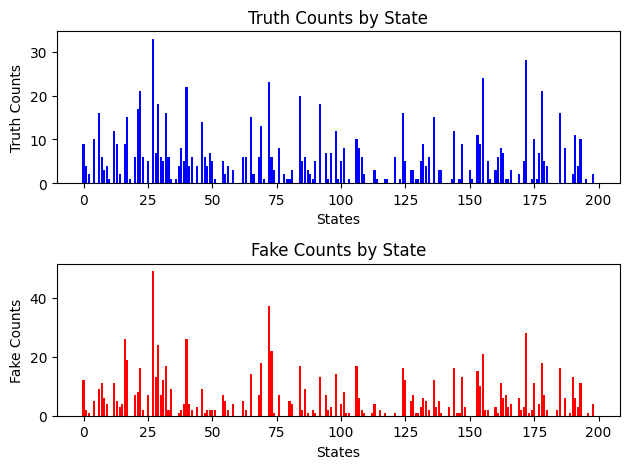

In [40]:

# # Separating the states, truth and fake counts into separate lists
# states = list(state_statics.keys())
# truth_counts = [state_statics[state]['truth'] for state in states]
# fake_counts = [state_statics[state]['fake'] for state in states]

# # Creating the bar charts
# fig, axs = plt.subplots(2)

# # Bar chart for 'truth' counts
# axs[0].bar(states, truth_counts, color='b')
# axs[0].set_title('Truth Counts by State')
# axs[0].set_xlabel('States')
# axs[0].set_ylabel('Truth Counts')

# # Bar chart for 'fake' counts
# axs[1].bar(states, fake_counts, color='r')
# axs[1].set_title('Fake Counts by State')
# axs[1].set_xlabel('States')
# axs[1].set_ylabel('Fake Counts')

# # Automatically adjust the subplot layout
# fig.tight_layout()

# plt.show()